<a href="https://colab.research.google.com/github/sergienko4/deep-learing/blob/main/ex6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Ex.6 - **Features visualization**

Submitted by: [... **your name and ID** ...]



In [14]:
# TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# PCA and tSNE:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

print(tf.__version__)

2.7.0


---
In this question we will use a "VGG-like" model (similar to the one you trained in past exercises) that was pre-trained on the CIFAR-10 dataset. you will need to download the model and put it in your working directory.

This model consists of the following layers: 

 - input (32x32x3) -> (Conv -> Conv -> Pool) -> (Conv -> Conv -> Pool) -> (Conv -> Conv -> Pool) -> 2048-Dense -> 10-output
 
There are also some batch-normalization and dropout layers in between. All `Conv2D` layers use 3x3 kernels with `padding='same'`.

We will use the 10,000 validation images of the CIFAR-10 dataset for the following analysis.

In [2]:
# download the pre-trained model:
!git clone https://github.com/rubinj/cifar_model.git

# load the model:
model = tf.keras.models.load_model('cifar_model/model.h5') 

for i,l in enumerate(model.layers):
    print('%-5i' % i,
          '%-20s' % (l.name,),
          '%s' % (l.output_shape[1:],))

Cloning into 'cifar_model'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
0     conv2d               (32, 32, 32)
1     batch_normalization  (32, 32, 32)
2     conv2d_1             (32, 32, 32)
3     batch_normalization_1 (32, 32, 32)
4     max_pooling2d        (16, 16, 32)
5     dropout              (16, 16, 32)
6     conv2d_2             (16, 16, 64)
7     batch_normalization_2 (16, 16, 64)
8     conv2d_3             (16, 16, 64)
9     batch_normalization_3 (16, 16, 64)
10    max_pooling2d_1      (8, 8, 64)
11    dropout_1            (8, 8, 64)
12    conv2d_4             (8, 8, 128)
13    batch_normalization_4 (8, 8, 128)
14    conv2d_5             (8, 8, 128)
15    batch_normalization_5 (8, 8, 128)
16    max_pooling2d_2      (4, 4, 128)
17    dropout_2            (4, 4, 128)
18    flatten              (

In [3]:
# download the cifar10 dataset:

from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
x_test.shape =  (10000, 32, 32, 3)
y_test.shape =  (10000, 1)


---
### 1. Embedding of the feature space in 2-D (using PCA)

In this question we will use our pre-trained model as a smart feature-extractor.
To this aim, we will use the output from the layer before the last one. This layer produces a 2048-D vector for any given image input of size (32,32,3).

- We will use this method, to extract a 2048-D features representation, for each of the 10,000 test images. 

- Use **PCA** to to reduce the dimensionality of the features **from 2048-D to 2-D**, and use a scatter plot to visualize all samples in this 2-D space. Color the samples by their true label (use the `tab10` color map).



In [74]:
def print_scatter_with_reduce_model(model, prediction, y):
  # colors = np.random.randint(100, size=(len(prediction)))
  x_reduced = model.fit_transform(prediction)
  x_cord = []
  y_cord = []
  for rec in x_reduced:
    x_cord.append(rec[0])
    y_cord.append(rec[1])

  plt.scatter(x_cord, y_cord, s=50,c=y,cmap='tab10', alpha=0.5)

In [75]:
activations = Model(inputs=model.inputs, outputs=model.layers[18].output)
prediction = activations.predict(x_test)


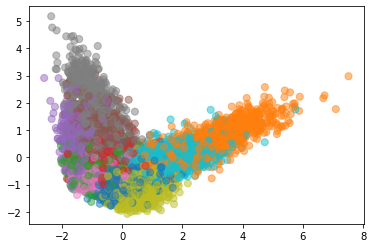

In [76]:
pca = PCA(n_components=2)
print_scatter_with_reduce_model(pca,prediction,y_test)


---
### 2. Embedding of the feature space in 2-D (using PCA + tSNE)

Usually, tSNE gives better results for this kind of task. The problem is that running tSNE on a large matrix (10,000 x 2,048), can take too long.

Therefore, we will first use **PCA** to reduce the dimensionality of the features: **from 2048-D to 50-D**.

Then, we will use **tSNE** to further reduce the dimensionality from **50-D to 2-D**.

As before, use a scatter plot to visualize all  samples in this 2-D space. Color the samples by their true label (use the `tab10` color map).




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


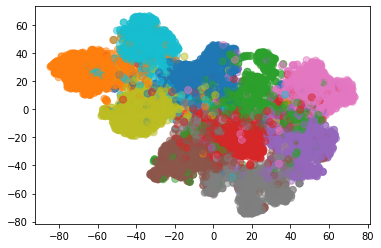

In [77]:
activations = Model(inputs=model.inputs, outputs=model.layers[18].output)
prediction = activations.predict(x_test)
x_reduced_to_50_d = PCA(n_components=50).fit_transform(prediction)
tsne = TSNE(n_components=2)
print_scatter_with_reduce_model(tsne,x_reduced_to_50_d,y_test)

---
### 3. Maximally activating patches - `conv2d_1` layer

In this question, we will explore the different filters along the pre-trained model.


- pick the **2nd conv** layer in the model (`conv2d_1`), and calculate its activation pattern for each and every of the 10,000 images. The result should be a tensor of size: (10000,32,32,32). 
- pick the **1st filter (channel) in that layer** (out of the 32 available), and look for the neuron with highest activations there (over all 32x32 neurons and 10,000 images). 
- Print the location `(i,j)` of this neuron and the index number (1-10,000) of the choosen image.
- Plot the corresponding patch in that image.

hint: `np.argmax` and `np.unravel_index` might come handy.


In [6]:
    ################################
    ###  your code goes here...  ###
    ################################

- now, instead of finding the single highest activation, find the **8 highest activations** (in a descending order), for the same filter as before. In other words, out of the total (10000,32,32,1) activations find the highest 8.
- find the corresponding image patch for each of these 8 activations, and plot them in a single row of subplots.

In [7]:
    ################################
    ###  your code goes here...  ###
    ################################

- finally, repeat the same process for **9 more filters** (channels) in the same layer (`conv2d_1`): for each of these filters, find the 8 highest activations and extract their corresponding image patches.

- plot all the patches you extracted (total 10x8 patches: 10 filters x 8 patches for each one). Use `10x8` subplots.

In [8]:
    ################################
    ###  your code goes here...  ###
    ################################

---
### 4. Maximally activating patches - `conv2d_2` layer

Repeat the same process for a different layer now: `conv2d_2`.

- Extract all activations of that filter: (10000,16,16,64)

- Pick 10 filters (out of its 64), and find the 8 highest activations for each filter.

- plot all the patches you extracted (total 10x8 patches: 10 filters x 8 patches for each one). Use 10x8 subplots.



In [9]:
    ################################
    ###  your code goes here...  ###
    ################################

---
### 5. Maximally activating patches - `conv2d_3` layer

Repeat the same process for a different layer now: `conv2d_3`.

- Extract all activations of that filter: (10000,16,16,64)

- Pick 10 filters (out of its 64), and find the 8 highest activations for each filter.

- plot all the patches you extracted (total 10x8 patches: 10 filters x 8 patches for each one). Use 10x8 subplots.


Pay careful attention to the way you transform the index `(i,j)` in the activation layer to the correct patch in the image.. 

You should get results similar to the ones in the presentation slides.

In [10]:
    ################################
    ###  your code goes here...  ###
    ################################

***
## Good Luck!